# Problem Definition  


In this assignment, we want to implement a convolutional neural network from scratch (Just using NumPy). For this purpose, the UTKFace dataset was used, includes more than 23000 face images of peoples of different ages, races, and genders. In the first section of question 1, I train an artificial neural network for age prediction, then in the second part for race prediction, and last for gender prediction. 


In [ ]:
#Importing required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import os, sys
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
 
np.random.seed(2045) # because singularity is near :) 

# Question 1 : 



### Load Data 

Upload the dataset to drive, and before that mount google drive.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For the sake of speed, copy the folder to the root directory and unziped it. 

In [ ]:
!cp /content/drive/My\ Drive/UTKFace.tar.gz ./

In [ ]:
!tar xf /content/UTKFace.tar.gz

In [ ]:
folder = "/content/UTKFace"
images_names = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

In [ ]:
print(len(images_names))

17260


In [ ]:
images_names[1]

'26_0_1_20170113134653322.jpg.chip.jpg'

In [ ]:
images_names[1].split("_")

['26', '0', '1', '20170113134653322.jpg.chip.jpg']

In [ ]:
images_names.remove("39_1_20170116174525125.jpg.chip.jpg")
images_names.remove("61_1_20170109150557335.jpg.chip.jpg")
images_names.remove("61_1_20170109142408075.jpg.chip.jpg")
images_names.remove("111_1_0_20170120134646399.jpg.chip.jpg")
images_names.remove("103_0_2_20170112213001988.jpg.chip.jpg")

In [ ]:
names_splits = [name.split('_') for name in images_names]
Ages = np.array([int(l[0]) for l in names_splits ]).reshape(-1,1)
Genders = np.array([int(l[1]) for l in names_splits ]).reshape(-1,1)
Races = np.array([int(l[2]) for l in names_splits ]).reshape(-1,1)

In [ ]:
images = []
for name in images_names:
    img = Image.open(folder + "/" + name)
    images.append(np.array(img))

In [ ]:
X = np.array(images)

In [ ]:
X.shape

In [ ]:
del images,names_splits,images_names

## Implementation

### Activation Functions

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = (1/(1 + np.exp(-z)))
    
    return s

def sigmoid_backward(dA,Z):
    """

    """
    
    dZ = dA * sigmoid(Z)*(1 - sigmoid(Z)) 

    return dZ 


In [ ]:
def tanh(z):
    """
    Compute the tangent hyperbolic of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- tanh(z) as a numpy array 
    """
    
    s = np.tanh(z)

    return s

def tanh_backward(dA,Z):
    """

    """

    dZ = dA * [1 - (tanh(Z) ** 2)]

    return dZ 

In [ ]:
def relu(z):
    """
    Compute the Rectified Linear Unit(ReLU)  of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- max(0,z) as a numpy array 
    """

    s = z * (z > 0)

    return s

def relu_backward(dA,Z):
    """

    """
    dZ = dA * [np.all(Z > 0) *1 + np.all(Z <= 0) * 0 ]
    return dZ 

In [ ]:
def leaky_relu(z):
    """
    Compute the leaky relu of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- max(z,0.01*z) as a numpy array 
    """
    
    s1 = z * (z > 0)
    s2 = 0.01 * z * (z <= 0)
    s = s1 + s2 
    
    return s

def leaky_relu_backward(dA,Z):
    """

    """

    dZ = dA * np.where(Z > 0, 1, 0.01)

    return dZ 

In [ ]:
def softmax(z):
    """
    Compute the softmax of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- softmax(z) as a numpy array 
    """
    max_z = np.max(z,axis = 0,keepdims = True)
    s = np.exp(z - max_z) / np.sum(np.exp(z - max_z), axis=0)
    #s = np.exp(z) / np.sum(np.exp(z), axis=0)
    return s

def softmax_backward(dA,Z):
    """

    """
    #print("dA :",dA.shape,"Z :",Z.shape)
    AL = softmax(Z)
    dZ = dA * (AL - AL ** 2 )
    return dZ #(AL - 1) * Y    

### Neural Network 

In [ ]:
class DNN():

  def __init__(self,layer_dims,activation = 'relu',last_layer_activation = 'sigmoid',
               parameter_initialization = 'random',loss = 'L2',learning_rate_type = 'constant decay',
               learning_rate_init = 0.01,learning_rate_decay = 0.9 ,num_epoch_decay = 10,
               max_epochs = 100,batch_size = 128,momentum=0.9):
    
    self.layer_dims = layer_dims 
    self.L = len(layer_dims) - 1           # number of layers in the network
    self.parameters = {}              # use dictionary containing parameters "W1", "b1", ..., "WL", "bL" 
    self.activation = activation
    self.last_layer_activation = last_layer_activation 
    self.parameter_initialization = parameter_initialization
    self.loss = loss
    self.caches = {}
    self.grads = {}
    self.learning_rate_type = learning_rate_type
    self.learning_rate_init = learning_rate_init
    self.learning_rate = learning_rate_init
    self.learning_rate_decay = learning_rate_decay
    self.num_epoch_decay = num_epoch_decay
    self.iter = 1 # # of iters 
    self.epoch = 1 # # of epochs
    self.max_epochs = max_epochs
    self.momentum = momentum 
    self.V = {} # for store average of dw and db 
    self.batch_size = batch_size 

  def initialize_parameters(self):  #TODO: add pther types of initialization 
    """
    Arguments:
    layer_dims -- a list containing the dimensions of each layer in our network
    
    Returns:
    parameters -- a dictionary containing network parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(2045)
    if self.parameter_initialization == 'random':
        for l in range(1, self.L +1):
            self.V['dW' + str(l)] = np.zeros((self.layer_dims[l],self.layer_dims[l-1]))
            self.parameters['W' + str(l)] = np.random.randn(self.layer_dims[l],self.layer_dims[l-1]) * 0.01
            
            self.V['db' + str(l)] = np.zeros((self.layer_dims[l],1))
            self.parameters['b' + str(l)] = np.zeros((self.layer_dims[l],1))
            
            assert(self.parameters['W' + str(l)].shape == (self.layer_dims[l], self.layer_dims[l-1]))
            assert(self.parameters['b' + str(l)].shape == (self.layer_dims[l], 1))

    elif self.parameter_initialization == 'zero':
        for l in range(1, self.L +1):
            self.V['dW' + str(l)] = np.zeros((self.layer_dims[l],self.layer_dims[l-1]))
            self.parameters['W' + str(l)] = np.zeros((self.layer_dims[l],self.layer_dims[l-1]))
            
            self.V['db' + str(l)] = np.zeros((self.layer_dims[l],1))
            self.parameters['b' + str(l)] = np.zeros((self.layer_dims[l],1))
            
            assert(self.parameters['W' + str(l)].shape == (self.layer_dims[l], self.layer_dims[l-1]))
            assert(self.parameters['b' + str(l)].shape == (self.layer_dims[l], 1))

    return 
    

  def linear_activation_forward(self,A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: 
                  "sigmoid", "relu", "leaky_relu", "tanh", "softmax" , "identity"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z = np.dot(W,A_prev) + b  
        A = sigmoid(Z)  
    
    elif activation == "relu":
        Z = np.dot(W,A_prev) + b
        A = relu(Z)
    
    elif activation == "leaky_relu":
        Z = np.dot(W,A_prev) + b
        A = leaky_relu(Z)

    elif activation == "tanh":
        Z = np.dot(W,A_prev) + b
        A = tanh(Z)
        
    elif activation == "softmax":
        Z = np.dot(W,A_prev) + b
        A = softmax(Z)
        
    elif activation == "identity":
        Z = np.dot(W,A_prev) + b
        A = Z

    assert (A.shape == (W.shape[0], A_prev.shape[1]))

    return A, Z

  def forward(self,X):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """
    A = X
    L = self.L   # number of layers

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, Z = self.linear_activation_forward(A_prev,self.parameters['W' + str(l)],self.parameters['b' + str(l)],self.activation)
        self.caches[str(l)] = (A_prev,Z)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, ZL = self.linear_activation_forward(A,self.parameters['W' + str(L)],self.parameters['b' + str(L)],self.last_layer_activation)
    self.caches[str(L)] = (A,ZL)
    
    assert(AL.shape == (self.layer_dims[-1],X.shape[1]))
            
    return AL

  def compute_cost(self, AL, Y): # without Regularization 
    """  
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    if self.loss == 'L2' or self.loss == 'MSE':
      cost = (1/(2*m)) * ((Y - AL) @ (Y - AL).T)
      cost = np.squeeze(cost)

    elif self.loss == 'BCE'or self.loss == "Logistic loss":    
      # Compute loss from aL and y.
      cost = (-1/m) * np.sum(Y * np.log(AL) + (1-Y) * np.log(1-AL) )
      cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    elif self.loss == "NLL" :
      cost = (-1/m) * np.sum(np.log(np.sum(Y * AL,axis = 0)))
      cost = np.squeeze(cost)
      
    assert(cost.shape == ())
    
    return cost
  
  def linear_backward(self,dZ,W,A_prev):

    dW = np.dot(dZ,A_prev.T)
    db = np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)

    return dA_prev, dW, db 

  def linear_activation_backward(self,dA,cache,parameter,activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev,Z = cache
    W = parameter

    if activation == "relu":
        dZ = relu_backward(dA,Z)
        dA_prev, dW, db = self.linear_backward(dZ,W,A_prev)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,Z)
        #dZ = dA
        dA_prev, dW, db = self.linear_backward(dZ,W,A_prev)

    elif activation == "leaky_relu":
        dZ = leaky_relu_backward(dA,Z)
        dA_prev, dW, db = self.linear_backward(dZ,W,A_prev)

    elif activation == "tanh":
        dZ = tanh_backward(dA,Z)
        dA_prev, dW, db = self.linear_backward(dZ,W,A_prev)
        
    elif activation == "softmax":
        dZ = softmax_backward(dA,Z)
        dA_prev, dW, db = self.linear_backward(dZ,W,A_prev)
    
    elif activation == "identity":
        dZ = dA
        dA_prev, dW, db = self.linear_backward(dZ,W,A_prev)

    return dA_prev, dW, db
  
  def backward(self,AL,Y):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    L = self.L   # number of layers

    # Initializing the backpropagation
    if self.loss == 'L2' or self.loss == 'MSE':
        dAL = (1/m) * (AL - Y)

    elif self.loss == 'BCE' or self.loss == "Logistic loss":   
        dAL = (-1/m) * (np.divide(Y, AL) - np.divide((1 - Y), (1 - AL)))
        #dAL = (1/m) * (AL - Y)
    elif self.loss == "NLL" : 
        dAL = (-1/m) * ((1/AL) * Y)

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"
    self.grads["dA" + str(L-1)], self.grads["dW" + str(L)], self.grads["db" + str(L)]=\
     self.linear_activation_backward(dAL,self.caches[str(L)],self.parameters["W"+str(L)],activation = self.last_layer_activation)

    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        self.grads["dA" + str(l)],self.grads["dW" + str(l + 1)],self.grads["db" + str(l + 1)] =\
        self.linear_activation_backward(self.grads["dA"+str(l+1)],self.caches[str(l+1)],self.parameters["W"+str(l+1)],activation = self.activation)

    return 
    

  def update_parameters(self):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    L = self.L # number of layers in the neural network
    B = self.momentum 
    self.iter += 1

    # Update rule for each parameter. 
    for l in range(L):
        self.V["dW" + str(l+1)] = B * self.V["dW" + str(l+1)] + (1 - B) * self.grads["dW" + str(l+1)]
        self.V["db" + str(l+1)] = B * self.V["db" + str(l+1)] + (1 - B) * self.grads["db" + str(l+1)] 

        self.parameters["W" + str(l+1)] -= self.learning_rate * self.V["dW" + str(l+1)]
        self.parameters["b" + str(l+1)] -= self.learning_rate * self.V["db" + str(l+1)]

    return 

  def update_learning_rate(self):
    """

    """
    if self.learning_rate_type == 'constant decay' :
        self.learning_rate = self.learning_rate * self.learning_rate_decay 

    elif self.learning_rate_type == 'step decay' :  
        self.learning_rate = self.learning_rate_init * math.pow(self.learning_rate_decay,  math.floor((1+self.epoch)/self.num_epoch_decay))
    else : 
        print ("Warning! The Learning rate that you gave didn't were implemented")
    
    self.epoch += 1
  
  def one_hot_coding(self,Y,classes = None):
    """

    """
    if classes is None : classes = np.unique(Y)
    c = len(classes)
    a = np.zeros((c,Y.shape[1]))
    for i in range(Y.shape[1]):
        y = Y[0,i]
        x = np.zeros((c,))
        x[np.where(classes == y)] = 1
        a[:,i] = x 

    return a 

  def fit(self,X,Y,X_val = None,Y_val = None,print_cost=False,
          print_accuracy = False,plot_cost=False,plot_accuracy = False):
    assert (Y.ndim > 1)
    np.random.seed(2045)
    m = X.shape[1]
    if self.last_layer_activation == "softmax" and Y.shape[0] == 1: Y = self.one_hot_coding(Y)

    costs = [[],[]]
    accs = [[],[]]
    val_flag = X_val is not None and Y_val is not None
    acc_flag = print_accuracy or plot_accuracy
        
    # initialize_parameters :
    self.initialize_parameters()

    # for 
    for i in range(1,self.max_epochs+1):
        print("-"*30)
        cost_batches = [[],[]]
        acc_batches = [[],[]]
        for j in range(math.ceil(m / self.batch_size)):
            
            if val_flag :
                if self.last_layer_activation == "softmax" and Y_val.shape[0] == 1: Y_val = self.one_hot_coding(Y_val)
                AL_val = self.forward(X_val)
                cost_val = self.compute_cost(AL_val, Y_val)
                cost_batches[1].append(cost_val)
                if acc_flag :
                    if self.last_layer_activation == "sigmoid" : 
                        AL_val = np.around(AL_val)
                        acc_val = accuracy_score(Y_val[0,:],AL_val[0,:])
                    if self.last_layer_activation == "softmax":
                        acc_val = accuracy_score(np.argmax(Y_val,axis = 0), np.argmax(AL_val,axis = 0))
                    acc_batches[1].append(acc_val)

            Xt = X[:,j*self.batch_size: (j+1) * self.batch_size]
            Yt = Y[:,j*self.batch_size: (j+1) * self.batch_size]

            # Forward propagation 
            AL = self.forward(Xt)

            # Compute loss 
            cost = self.compute_cost(AL, Yt)
            cost_batches[0].append(cost)  

            #print("cost :",cost)
            #print("AL :",AL)
            # Implement backward propagation to get the gradients 
            self.backward(AL,Yt)

            # Update parameters
            self.update_parameters()

            if acc_flag :
                if self.last_layer_activation == "sigmoid" :
                    AL = np.around(AL)
                    acc = accuracy_score(Yt[0,:],AL[0,:])

                if self.last_layer_activation == "softmax" :
                    acc = accuracy_score(np.argmax(Yt,axis = 0), np.argmax(AL,axis = 0))
                
                acc_batches[0].append(acc)   

                        
        costs[0].append(np.mean(cost_batches[0]))
        costs[1].append(np.mean(cost_batches[1]))
        accs[0].append(np.mean(acc_batches[0]))
        accs[1].append(np.mean(acc_batches[1]))
        
        # Print the cost every 10 training example
        if print_cost :
            print("Cost of Train data after epoch %i: %f" %(self.epoch, costs[0][-1]))
            if val_flag : print("Cost of Validation data after epoch %i: %f" %(self.epoch, costs[1][-1]))
        
        if print_accuracy :
            print("Accuracy of Train data after epoch %i: %f" %(self.epoch,accs[0][-1]))
            if val_flag : print("Accuracy of Validation data after epoch %i: %f" %(self.epoch, accs[1][-1]))
        
        self.update_learning_rate()
        


    # plot the cost
    if plot_cost:
        plt.plot(np.squeeze(costs[0]))
        plt.plot(np.squeeze(costs[1]))
        plt.title("Cost of DNN vs Epochs ")
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        plt.legend(labels = ["Train","Validation"])
        plt.show()

    # plot the accuracy 
    if plot_accuracy :
        plt.plot(np.squeeze(accs[0]))
        plt.plot(np.squeeze(accs[1]))
        plt.title("Accuracy of DNN vs Epochs ")
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(labels = ["Train","Validation"])
        plt.show()        

    return costs,accs

  def predict(self,X,Y):
    """

    """
    y_pred = self.forward(X)
    if self.last_layer_activation == "sigmoid" :
        y_pred = np.around(y_pred)

    if self.last_layer_activation == "softmax" and Y.shape[0] == 1:
        y_pred = np.argmax(y_pred,axis = 0)
        y_pred = y_pred.reshape(1,-1)
    
    assert (y_pred.shape == Y.shape) 
    
    return y_pred

### Test on a Baseline
 (for sanity check)

A_prev [[ 0.06169621 -0.05147406  0.04445121 -0.01159501 -0.03638469 -0.04069594
  -0.04716281 -0.00189471  0.06169621  0.03906215 -0.08380842  0.01750591
  -0.02884001 -0.00189471 -0.02560657 -0.01806189  0.04229559  0.01211685
  -0.0105172  -0.01806189 -0.05686312 -0.02237314 -0.00405033  0.06061839
   0.03582872 -0.01267283 -0.07734155  0.05954058 -0.02129532 -0.00620595
   0.04445121 -0.06548562  0.12528712 -0.05039625 -0.06332999 -0.03099563
   0.02289497  0.01103904  0.07139652  0.01427248 -0.00836158 -0.06764124
  -0.0105172  -0.02345095  0.06816308 -0.03530688 -0.01159501 -0.0730303
  -0.04177375  0.01427248 -0.00728377  0.0164281  -0.00943939 -0.01590626
   0.0250506  -0.04931844  0.04121778 -0.06332999 -0.06440781 -0.02560657
  -0.00405033  0.00457217 -0.00728377 -0.0374625 ]]
W1 [[ 0.13315865]
 [ 0.0715279 ]
 [-0.15454003]
 [-0.00083838]
 [ 0.0621336 ]
 [-0.07200856]
 [ 0.02655116]
 [ 0.01085485]
 [ 0.00042914]
 [-0.01746002]
 [ 0.04330262]
 [ 0.12030374]
 [-0.09650657]
 [ 0

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
 [ 1.47884153e-02]
 [ 3.28166153e-01]]
* [[ 0.15417434  0.14918043  0.15341531 ...  0.15147218  0.15082613
   0.14960773]
 [-0.02526132 -0.02394047 -0.02516099 ... -0.02495224 -0.02489863
  -0.02442219]
 [ 0.04446959  0.04720974  0.04487943 ...  0.04567407  0.0458546
   0.04658344]
 ...
 [ 0.03733582  0.03877625  0.03731275 ...  0.03777094  0.03809329
   0.03857462]
 [-0.00746599 -0.0052776  -0.00752613 ... -0.00702399 -0.0066414
  -0.00571953]
 [ 0.40933156  0.40445812  0.40893719 ...  0.4075205   0.40691566
   0.40524815]]
Z : (32, 64) [[ 0.15417434  0.14918043  0.15341531 ...  0.15147218  0.15082613
   0.14960773]
 [-0.02526132 -0.02394047 -0.02516099 ... -0.02495224 -0.02489863
  -0.02442219]
 [ 0.04446959  0.04720974  0.04487943 ...  0.04567407  0.0458546
   0.04658344]
 ...
 [ 0.03733582  0.03877625  0.03731275 ...  0.03777094  0.03809329
   0.03857462]
 [-0.00746599 -0.0052776  -0.00752613 ... -0.00702399 -0.0066414
  -0.0057195

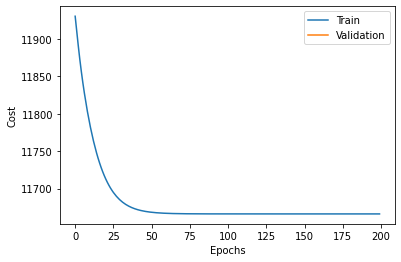

TypeError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20].reshape(1,-1)
diabetes_X_test = diabetes_X[-20:].reshape(1,-1)

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20].reshape(1,-1)
diabetes_y_test = diabetes_y[-20:].reshape(1,-1)


layer_dims = [diabetes_X_train.shape[0],32,32,1]
model = DNN(layer_dims,activation = 'leaky_relu',last_layer_activation = 'leaky_relu',learning_rate_init = 0.001,batch_size =64,max_epochs = 200,momentum = 0)

model.fit(diabetes_X_train,diabetes_y_train,print_cost= True,plot_cost = True)

y_pred = model.predict(diabetes_X_test)

## Section 1 



### Preprocessing 

#### Train/Val/Test Split 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Ages, test_size=0.1,stratify = Ages, random_state=2045)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,stratify = y_train, random_state=2045)

In [ ]:
del X,Ages

#### Normalization 

In [ ]:
X_train = X_train.astype('float16')
X_val = X_val.astype('float16')
X_test = X_test.astype('float16')

In [ ]:
mu = np.mean(X_train,axis = 0)

In [ ]:
sec_mom = np.mean(np.power(X_train,2),axis = 0) 
sig = np.sqrt(sec_mom - np.power(mu,2)) 
del sec_mom

In [ ]:
X_train -= mu 
X_val -= mu
X_test -= mu
del mu 
X_train /= sig
X_val /= sig
X_test /= sig 
del sig

#### Dimension Reduction 

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3])

X_val = X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2]*X_val.shape[3])

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3])

In [ ]:
X_train.shape

(19198, 120000)

In [ ]:
n_components = 128
ipca = IncrementalPCA(n_components = n_components, batch_size= 16)
m = X_train.shape[0]
chunk_size = 240

for i in range(0, m//chunk_size):
    ipca.partial_fit(X_train[i*chunk_size : (i+1)*chunk_size,:])

In [ ]:
X_train_new = np.zeros((X_train.shape[0],128),dtype = 'float16')
for i in range(0, m//chunk_size):
    X_train_new[i*chunk_size : (i+1)*chunk_size,:] = ipca.transform(X_train[i*chunk_size : (i+1)*chunk_size,:])

In [ ]:
del X_train 
X_train = X_train_new 
del X_train_new 

In [ ]:
X_val = ipca.transform(X_val)
X_test = ipca.transform(X_test)

#### Normalization after pca 

In [ ]:
sig = 0
m = X_train.shape[0]
for x in X_train:
    x = x.astype('float64')
    sig += (1/m) * (x ** 2)

sig = np.sqrt(sig)
sig = sig.astype('float16')

In [ ]:
X_train /= sig
X_val /= sig
X_test /= sig 
del sig

In [ ]:
np.std(X_test),np.std(X_val)

(1.0079457722676377, 1.0098281068125565)

#### Save The Normalize Data after *PCA*

In [ ]:
pd.DataFrame(X_train).to_csv('drive/My Drive/X_train.csv')
pd.DataFrame(X_val).to_csv('drive/My Drive/X_val.csv')
pd.DataFrame(X_test).to_csv('drive/My Drive/X_test.csv')

pd.DataFrame(y_train).to_csv('drive/My Drive/y_train.csv')
pd.DataFrame(y_val).to_csv('drive/My Drive/y_val.csv')
pd.DataFrame(y_test).to_csv('drive/My Drive/y_test.csv')

### Load Saved Data 

In [ ]:
X_train = pd.read_csv("/content/drive/My Drive/X_train.csv")
X_val = pd.read_csv("/content/drive/My Drive/X_val.csv")
X_test = pd.read_csv("/content/drive/My Drive/X_test.csv")

y_train = pd.read_csv("/content/drive/My Drive/y_train.csv")
y_val = pd.read_csv("/content/drive/My Drive/y_val.csv")
y_test = pd.read_csv("/content/drive/My Drive/y_test.csv")

In [ ]:
X_train.drop(X_train.columns[[0]], axis = 1,inplace = True )
X_val.drop(X_val.columns[[0]], axis = 1,inplace = True )
X_test.drop(X_test.columns[[0]], axis = 1,inplace = True )

y_train.drop(y_train.columns[[0]], axis = 1,inplace = True )
y_val.drop(y_val.columns[[0]], axis = 1,inplace = True )
y_test.drop(y_test.columns[[0]], axis = 1,inplace = True )

In [ ]:
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T

y_train = y_train.T
y_val = y_val.T
y_test = y_test.T

### Part a 

###### Zero Initialization 

------------------------------


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cost of Train data after epoch 1: 686.270097
Cost of Validation data after epoch 1: 682.508139
------------------------------
Cost of Train data after epoch 2: 564.477385
Cost of Validation data after epoch 2: 561.058437
------------------------------
Cost of Train data after epoch 3: 480.761558
Cost of Validation data after epoch 3: 477.613734
------------------------------
Cost of Train data after epoch 4: 421.953907
Cost of Validation data after epoch 4: 419.019888
------------------------------
Cost of Train data after epoch 5: 379.595198
Cost of Validation data after epoch 5: 376.832035
------------------------------
Cost of Train data after epoch 6: 348.390317
Cost of Validation data after epoch 6: 345.765327
------------------------------
Cost of Train data after epoch 7: 324.933057
Cost of Validation data after epoch 7: 322.421015
------------------------------
Cost of Train data after epoch 8: 306.976864
Cost of Validation data after epoch 8: 304.558045
-----------------------

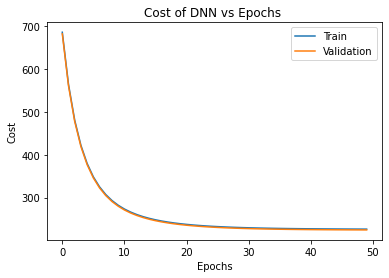

In [ ]:
layer_dims = [128,64,32,1]
model_1a = DNN(layer_dims,activation = 'leaky_relu',last_layer_activation = 'leaky_relu', parameter_initialization = 'zero',
            learning_rate_init = 0.001,learning_rate_decay = 0.9,batch_size=128,max_epochs = 50)

costs_1a,accs_1a = model_1a.fit(X_train,y_train,X_val,y_val,print_cost= True,plot_cost = True)

In [ ]:
y_pred_1a = model_1a.predict(X_test,y_test) 
mse_1a = mean_squared_error(y_test,y_pred_1a)
rmse_1a = np.sqrt(mse_1a)
print(rmse_1a)

21.06860824788658


##### Random Initialization

------------------------------


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cost of Train data after epoch 1: 680.772261
Cost of Validation data after epoch 1: 676.906467
------------------------------
Cost of Train data after epoch 2: 238.909674
Cost of Validation data after epoch 2: 235.875193
------------------------------
Cost of Train data after epoch 3: 106.088113
Cost of Validation data after epoch 3: 105.264099
------------------------------
Cost of Train data after epoch 4: 101.663248
Cost of Validation data after epoch 4: 102.066183
------------------------------
Cost of Train data after epoch 5: 97.708431
Cost of Validation data after epoch 5: 99.202024
------------------------------
Cost of Train data after epoch 6: 94.606706
Cost of Validation data after epoch 6: 97.048648
------------------------------
Cost of Train data after epoch 7: 92.238593
Cost of Validation data after epoch 7: 95.486580
------------------------------
Cost of Train data after epoch 8: 90.420205
Cost of Validation data after epoch 8: 94.394106
------------------------------


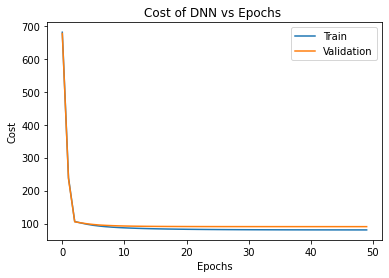

In [ ]:
layer_dims = [128,64,32,1]
model_1a_ = DNN(layer_dims,activation = 'leaky_relu',last_layer_activation = 'leaky_relu', parameter_initialization = 'random',
            learning_rate_init = 0.001,learning_rate_decay = 0.9,batch_size=128,max_epochs = 50)

costs_1a_,accs_1a_ = model_1a_.fit(X_train,y_train,X_val,y_val,print_cost= True,plot_cost = True)

In [ ]:
y_pred_1a_ = model_1a_.predict(X_test,y_test) 
mse_1a_ = mean_squared_error(y_test,y_pred_1a_)
rmse_1a_ = np.sqrt(mse_1a_)
print(rmse_1a_)

13.017013414415672


### Part b 

------------------------------


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cost of Train data after epoch 1: 680.772261
Cost of Validation data after epoch 1: 676.906467
------------------------------
Cost of Train data after epoch 2: 228.238853
Cost of Validation data after epoch 2: 225.248561
------------------------------
Cost of Train data after epoch 3: 105.866014
Cost of Validation data after epoch 3: 105.124777
------------------------------
Cost of Train data after epoch 4: 100.568442
Cost of Validation data after epoch 4: 101.241765
------------------------------
Cost of Train data after epoch 5: 96.064251
Cost of Validation data after epoch 5: 97.949155
------------------------------
Cost of Train data after epoch 6: 92.835098
Cost of Validation data after epoch 6: 95.800351
------------------------------
Cost of Train data after epoch 7: 90.554675
Cost of Validation data after epoch 7: 94.374794
------------------------------
Cost of Train data after epoch 8: 88.859468
Cost of Validation data after epoch 8: 93.459388
------------------------------


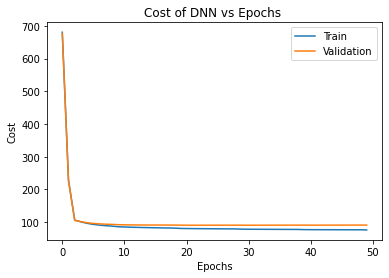

In [ ]:
layer_dims = [128,64,32,1]
model_1b = DNN(layer_dims,activation = 'leaky_relu',last_layer_activation = 'leaky_relu',learning_rate_type = 'step decay',
            learning_rate_init = 0.001,learning_rate_decay = 0.7,num_epoch_decay = 10,batch_size=128,max_epochs = 50)

costs_1b,accs_1b = model_1b.fit(X_train,y_train,X_val,y_val,print_cost= True,plot_cost = True)

In [ ]:
y_pred_1b = model_1b.predict(X_test,y_test)
mse_1b = mean_squared_error(y_test,y_pred_1b)
rmse_1b = np.sqrt(mse_1b)
print(rmse_1b)

12.917843593563166


## Section 2 

### Preprocessing 

#### Train/Val/Test Split 

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Races, test_size=0.1,stratify = Races, random_state=2045)

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.1,stratify = y_train2, random_state=2045)

In [ ]:
del X,Races

#### Normalization 

In [ ]:
X_train2 = X_train2.astype('float16')
X_val2 = X_val2.astype('float16')
X_test2 = X_test2.astype('float16')

In [ ]:
mu = np.mean(X_train2,axis = 0)

In [ ]:
sec_mom = np.mean(np.power(X_train2,2),axis = 0) 
sig = np.sqrt(sec_mom - np.power(mu,2)) 
del sec_mom

In [ ]:
X_train2 -= mu 
X_val2 -= mu
X_test2 -= mu
del mu 
X_train2 /= sig
X_val2 /= sig
X_test2 /= sig 
del sig

#### Dimension Reduction 

In [ ]:
X_train2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1]*X_train2.shape[2]*X_train2.shape[3])

X_val2 = X_val2.reshape(X_val2.shape[0],X_val2.shape[1]*X_val2.shape[2]*X_val2.shape[3])

X_test2 = X_test2.reshape(X_test2.shape[0],X_test2.shape[1]*X_test2.shape[2]*X_test2.shape[3])

In [ ]:
X_train2.shape

(19198, 120000)

In [ ]:
n_components = 128
ipca = IncrementalPCA(n_components = n_components, batch_size= 16)
m = X_train2.shape[0]
chunk_size = 240

for i in range(0, m//chunk_size):
    ipca.partial_fit(X_train2[i*chunk_size : (i+1)*chunk_size,:])

In [ ]:
X_train2_new = np.zeros((X_train2.shape[0],128),dtype = 'float16')
for i in range(0, m//chunk_size):
    X_train2_new[i*chunk_size : (i+1)*chunk_size,:] = ipca.transform(X_train2[i*chunk_size : (i+1)*chunk_size,:])

In [ ]:
del X_train2 
X_train2 = X_train2_new 
del X_train2_new 

In [ ]:
X_val2 = ipca.transform(X_val2)
X_test2 = ipca.transform(X_test2)

#### Normalization after pca 

In [ ]:
sig = 0
m = X_train2.shape[0]
for x in X_train2:
    x = x.astype('float64')
    sig += (1/m) * (x ** 2)

sig = np.sqrt(sig)
sig = sig.astype('float16')

In [ ]:
X_train2 /= sig
X_val2 /= sig
X_test2 /= sig 
del sig

In [ ]:
np.std(X_test2),np.std(X_val2)

(1.0088409362556043, 1.010495862384647)

#### Save The Normalize Data after *PCA*

In [ ]:
pd.DataFrame(X_train2).to_csv('drive/My Drive/X_train2.csv')
pd.DataFrame(X_val2).to_csv('drive/My Drive/X_val2.csv')
pd.DataFrame(X_test2).to_csv('drive/My Drive/X_test2.csv')

pd.DataFrame(y_train2).to_csv('drive/My Drive/y_train2.csv')
pd.DataFrame(y_val2).to_csv('drive/My Drive/y_val2.csv')
pd.DataFrame(y_test2).to_csv('drive/My Drive/y_test2.csv')

### Load Saved Data 

In [ ]:
X_train2 = pd.read_csv("/content/drive/My Drive/X_train2.csv")
X_val2 = pd.read_csv("/content/drive/My Drive/X_val2.csv")
X_test2 = pd.read_csv("/content/drive/My Drive/X_test2.csv")

y_train2 = pd.read_csv("/content/drive/My Drive/y_train2.csv")
y_val2 = pd.read_csv("/content/drive/My Drive/y_val2.csv")
y_test2 = pd.read_csv("/content/drive/My Drive/y_test2.csv")

In [ ]:
X_train2.drop(X_train2.columns[[0]], axis = 1,inplace = True )
X_val2.drop(X_val2.columns[[0]], axis = 1,inplace = True )
X_test2.drop(X_test2.columns[[0]], axis = 1,inplace = True )

y_train2.drop(y_train2.columns[[0]], axis = 1,inplace = True )
y_val2.drop(y_val2.columns[[0]], axis = 1,inplace = True )
y_test2.drop(y_test2.columns[[0]], axis = 1,inplace = True )

In [ ]:
X_train2 = X_train2.to_numpy()
X_val2 = X_val2.to_numpy()
X_test2 = X_test2.to_numpy()

y_train2 = y_train2.to_numpy()
y_val2 = y_val2.to_numpy()
y_test2 = y_test2.to_numpy()

In [ ]:
X_train2 = X_train2.T
X_val2 = X_val2.T
X_test2 = X_test2.T

In [ ]:
y_train2 = y_train2.T
y_val2 = y_val2.T
y_test2 = y_test2.T

### Part a

------------------------------
Cost of Train data after epoch 1: 1.605682
Cost of Validation data after epoch 1: 1.605663
Accuracy of Train data after epoch 1: 0.420925
Accuracy of Validation data after epoch 1: 0.420572
------------------------------
Cost of Train data after epoch 2: 1.597396
Cost of Validation data after epoch 2: 1.597377
Accuracy of Train data after epoch 2: 0.425144
Accuracy of Validation data after epoch 2: 0.425023
------------------------------
Cost of Train data after epoch 3: 1.589363
Cost of Validation data after epoch 3: 1.589345
Accuracy of Train data after epoch 3: 0.425144
Accuracy of Validation data after epoch 3: 0.425023
------------------------------
Cost of Train data after epoch 4: 1.581613
Cost of Validation data after epoch 4: 1.581596
Accuracy of Train data after epoch 4: 0.425144
Accuracy of Validation data after epoch 4: 0.425023
------------------------------
Cost of Train data after epoch 5: 1.574144
Cost of Validation data after epoch 5: 1.5

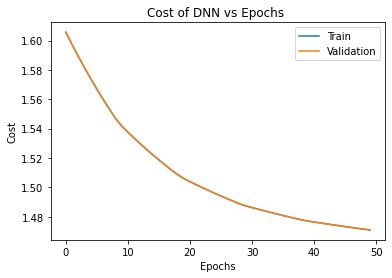

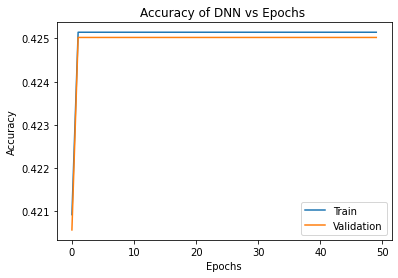

In [ ]:
layer_dims = [128,64,32,5]
model_2 = DNN(layer_dims,activation = 'leaky_relu',last_layer_activation = 'softmax',loss = 'NLL',learning_rate_type = 'step decay',
            learning_rate_init = 0.001,learning_rate_decay = 0.7,batch_size=128,max_epochs = 50)

costs_2,accs_2 = model_2.fit(X_train2,y_train2,X_val2,y_val2,print_cost= True,plot_cost = True,print_accuracy = True,plot_accuracy = True)

In [ ]:
y_pred2 = model_2.predict(X_test2,y_test2)

accuracy_score(y_test2[0,:],y_pred2[0,:])

0.4251370729649937

In [ ]:
print(len(np.where ( y_train2 == 0)[1]),len(np.where ( y_train2 == 1)[1]),\
      len(np.where ( y_train2 == 2)[1]),len(np.where ( y_train2 == 3)[1]),\
      len(np.where ( y_train2 == 4)[1]))

8162 3665 2781 3219 1371


## Section 3

### Preprocessing 

#### Train/Val/Test Split 

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Genders, test_size=0.1,stratify = Genders, random_state=2045)

X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size=0.1,stratify = y_train3, random_state=2045)

In [ ]:
del X,Genders

#### Normalization 

In [ ]:
X_train3 = X_train3.astype('float16')
X_val3 = X_val3.astype('float16')
X_test3 = X_test3.astype('float16')

In [ ]:
mu = np.mean(X_train3,axis = 0)

In [ ]:
sec_mom = np.mean(np.power(X_train3,2),axis = 0) 
sig = np.sqrt(sec_mom - np.power(mu,2)) 
del sec_mom

In [ ]:
X_train3 -= mu 
X_val3 -= mu
X_test3 -= mu
del mu 
X_train3 /= sig
X_val3 /= sig
X_test3 /= sig 
del sig

#### Dimension Reduction 

In [ ]:
X_train3 = X_train3.reshape(X_train3.shape[0],X_train3.shape[1]*X_train3.shape[2]*X_train3.shape[3])

X_val3 = X_val3.reshape(X_val3.shape[0],X_val3.shape[1]*X_val3.shape[2]*X_val3.shape[3])

X_test3 = X_test3.reshape(X_test3.shape[0],X_test3.shape[1]*X_test3.shape[2]*X_test3.shape[3])

In [ ]:
X_train3.shape

(19198, 120000)

In [ ]:
n_components = 128
ipca = IncrementalPCA(n_components = n_components, batch_size= 16)
m = X_train3.shape[0]
chunk_size = 240

for i in range(0, m//chunk_size):
    ipca.partial_fit(X_train3[i*chunk_size : (i+1)*chunk_size,:])

In [ ]:
X_train3_new = np.zeros((X_train3.shape[0],128),dtype = 'float16')
for i in range(0, m//chunk_size):
    X_train3_new[i*chunk_size : (i+1)*chunk_size,:] = ipca.transform(X_train3[i*chunk_size : (i+1)*chunk_size,:])

In [ ]:
del X_train3 
X_train3 = X_train3_new 
del X_train3_new 

In [ ]:
X_val3 = ipca.transform(X_val3)
X_test3 = ipca.transform(X_test3)

#### Normalization after pca 

In [ ]:
sig = 0
m = X_train3.shape[0]
for x in X_train3:
    x = x.astype('float64')
    sig += (1/m) * (x ** 2)

sig = np.sqrt(sig)
sig = sig.astype('float16')

In [ ]:
X_train3 /= sig
X_val3 /= sig
X_test3 /= sig 
del sig

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
np.std(X_test3),np.std(X_val3)

(29.228658764240777, 29.435895898859194)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train3)
X_train3 = scaler.transform(X_train3)
X_val3 = scaler.transform(X_val3)
X_test3 = scaler.transform(X_test3)

#### Save The Normalize Data after *PCA*

In [ ]:
pd.DataFrame(X_train3).to_csv('drive/My Drive/X_train3.csv')
pd.DataFrame(X_val3).to_csv('drive/My Drive/X_val3.csv')
pd.DataFrame(X_test3).to_csv('drive/My Drive/X_test3.csv')

pd.DataFrame(y_train3).to_csv('drive/My Drive/y_train3.csv')
pd.DataFrame(y_val3).to_csv('drive/My Drive/y_val3.csv')
pd.DataFrame(y_test3).to_csv('drive/My Drive/y_test3.csv')

### Load Saved Data 

In [ ]:
X_train3 = pd.read_csv("/content/drive/My Drive/X_train3.csv")
X_val3 = pd.read_csv("/content/drive/My Drive/X_val3.csv")
X_test3 = pd.read_csv("/content/drive/My Drive/X_test3.csv")

y_train3 = pd.read_csv("/content/drive/My Drive/y_train3.csv")
y_val3 = pd.read_csv("/content/drive/My Drive/y_val3.csv")
y_test3 = pd.read_csv("/content/drive/My Drive/y_test3.csv")

In [ ]:
X_train3.drop(X_train3.columns[[0]], axis = 1,inplace = True )
X_val3.drop(X_val3.columns[[0]], axis = 1,inplace = True )
X_test3.drop(X_test3.columns[[0]], axis = 1,inplace = True )

y_train3.drop(y_train3.columns[[0]], axis = 1,inplace = True )
y_val3.drop(y_val3.columns[[0]], axis = 1,inplace = True )
y_test3.drop(y_test3.columns[[0]], axis = 1,inplace = True )

In [ ]:
X_train3 = X_train3.to_numpy()
X_val3 = X_val3.to_numpy()
X_test3 = X_test3.to_numpy()

y_train3 = y_train3.to_numpy()
y_val3 = y_val3.to_numpy()
y_test3 = y_test3.to_numpy()

In [ ]:
X_train3 = X_train3.T
X_val3 = X_val3.T
X_test3 = X_test3.T

y_train3 = y_train3.T
y_val3 = y_val3.T
y_test3 = y_test3.T

### part a

------------------------------
Cost of Train data after epoch 1: 0.696362
Cost of Validation data after epoch 1: 0.691668
Accuracy of Train data after epoch 1: 0.516567
Accuracy of Validation data after epoch 1: 0.534046
------------------------------
Cost of Train data after epoch 2: 0.681733
Cost of Validation data after epoch 2: 0.677331
Accuracy of Train data after epoch 2: 0.570994
Accuracy of Validation data after epoch 2: 0.579694
------------------------------
Cost of Train data after epoch 3: 0.671602
Cost of Validation data after epoch 3: 0.666694
Accuracy of Train data after epoch 3: 0.605160
Accuracy of Validation data after epoch 3: 0.618201
------------------------------
Cost of Train data after epoch 4: 0.660968
Cost of Validation data after epoch 4: 0.655342
Accuracy of Train data after epoch 4: 0.630681
Accuracy of Validation data after epoch 4: 0.645336
------------------------------
Cost of Train data after epoch 5: 0.649137
Cost of Validation data after epoch 5: 0.6

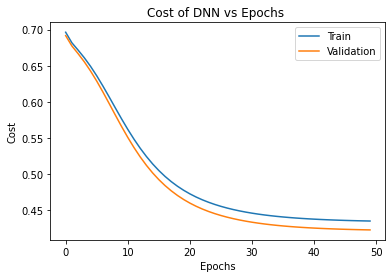

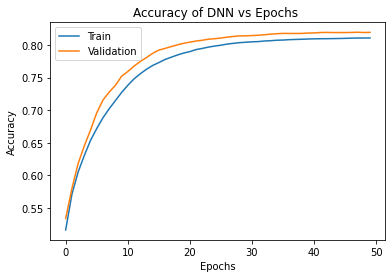

In [ ]:
layer_dims = [128,64,32,1]
model_3 = DNN(layer_dims,activation = 'leaky_relu',last_layer_activation = "sigmoid",loss = "Logistic loss",
            learning_rate_type = 'constant decay',learning_rate_init = 0.01,learning_rate_decay = 0.9,batch_size=128,max_epochs = 50)

costs_3,accs_3 = model_3.fit(X_train3,y_train3,X_val3,y_val3,print_cost= True,plot_cost = True,print_accuracy = True, plot_accuracy = True)

In [ ]:
y_pred3 = model_3.predict(X_test3,y_test3)
accuracy_score(y_test3[0,:],y_pred3[0,:])

0.8144242935470266